### Understanding Geospatial Data
This notebook will take you through some of the basic principles of working with geospatial datasets and give you an introduction to the ACLED conflict dataset we will be using.
#### Conflict tasks to get started
- How can we use the conflict events define an area as being affected by conflict?
- Each event is given a free text description. Can we extract useful information from this column?
- How/should we treat conflict events differently when they target civilians?

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)


In [ ]:
import pandas as pd
import geopandas as gpd
import os 
import io
module_path = os.path.abspath(os.path.join('../src'))
os.chdir(module_path)
from data.utils import *
import zipfile
import tempfile
import shutil
BUCKET = "q4-23-dataclinic-unicef-hackday"
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np

The file paths need to be edited to run the code as the the data was loaded from an s3 bucket before

In [ ]:
df = load_data(BUCKET, "CONFLICT/ACLED_data_Africa_Ucodes.csv").reset_index()
conflict_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'])).set_crs(4326)

In [ ]:
words = ['boy', 'girl', 'kid', 'child', 'underage', 'school', 'baby', 'babie']
pattern = '|'.join(words) 

df["children"] = df['notes'].str.contains(pattern, case=False, na=False)

In [ ]:
df["weighted_fatalities"] = np.where(df["civilian_targeting"] == "Civilian targeting", df["fatalities"] * 2, df["fatalities"]) 
df["weighted_fatalities"] = np.where(df["children"], df["fatalities"] * 2, df["fatalities"]) 

### Coordinate Reference Systems

In [ ]:
def child_conflict_map(df, country_name, country_code):
    country_map = load_data(bucket=BUCKET, path = "BOUNDARIES/ADMIN_2/Africa_bnd_adm2.shp").query("adm0_name == @country_name")
    country_pop = load_data(bucket=BUCKET, path = f"POPULATION/{country_code}_SAP_1km_2020/{country_code}_child_population.geojson")
    #events_df = load_data(BUCKET, "CONFLICT/ACLED_data_Africa_Ucodes.csv").reset_index()
    events_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'])).set_crs(4326).query("country == @country_name")

    pop_by_admn2 = country_pop.overlay(country_map).groupby("adm2_name")["pop_children_total"].sum().reset_index()
    fatalities_by_adm2 = events_gdf.overlay(country_map).groupby("adm2_name")["weighted_fatalities"].sum().reset_index()

    plot_dat = country_map.merge(fatalities_by_adm2, how = "left").merge(pop_by_admn2, how = "left")
    plot_dat["child_conflict_intensity"] = np.log(plot_dat["weighted_fatalities"] * plot_dat["pop_children_total"])
    plot_dat["child_conflict_intensity"] = plot_dat["child_conflict_intensity"] / plot_dat["child_conflict_intensity"].max()

    out = (ggplot() + 
    geom_map(plot_dat, aes(fill = "child_conflict_intensity")))

    return out

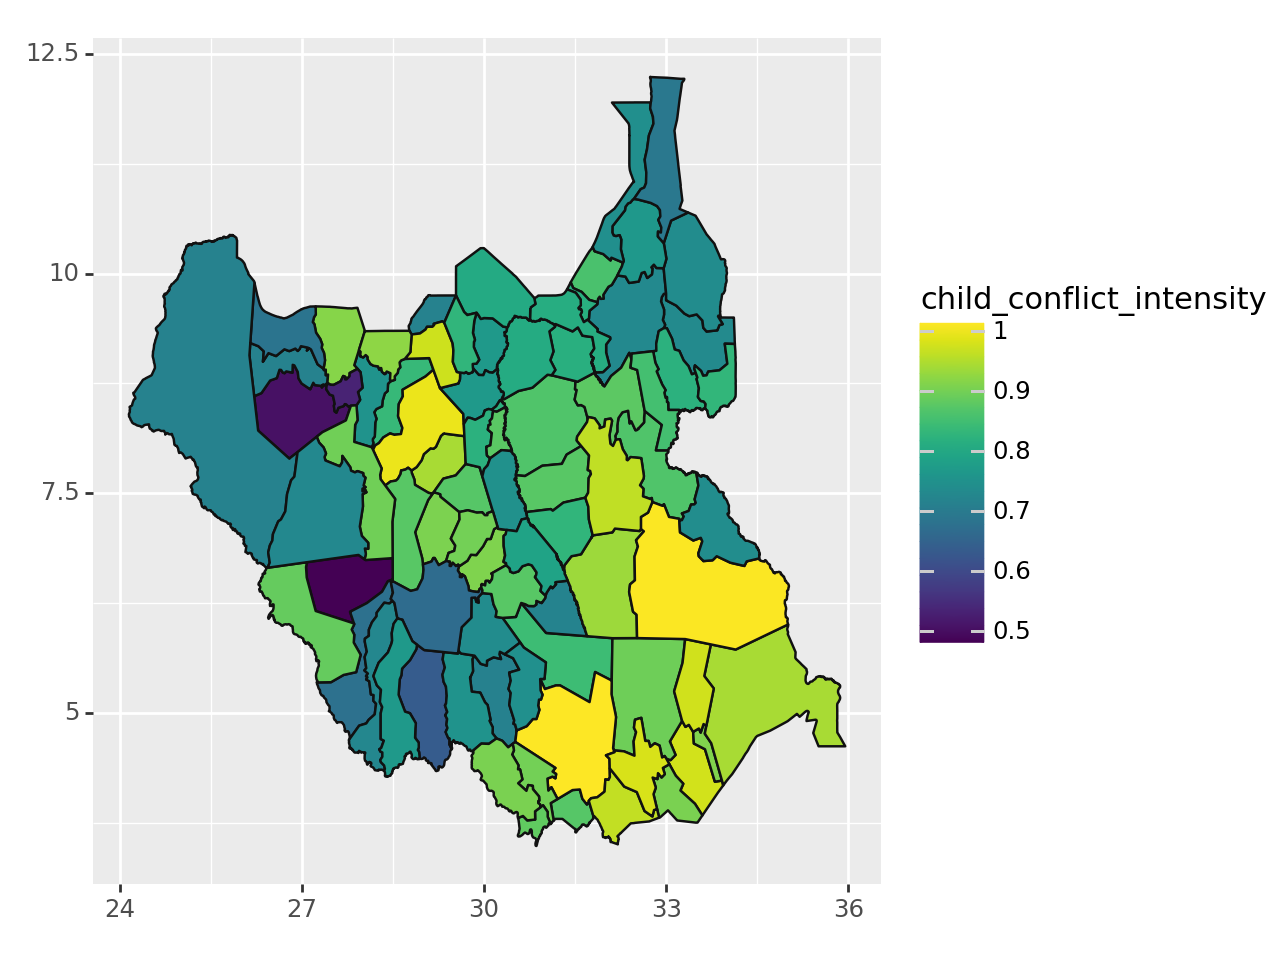

<Figure Size: (640 x 480)>

In [29]:
child_conflict_map(df.query("year > 2018"), "South Sudan", "SSD")

/home/tsdist/vats_deployments/modeling.env.interactive-1170ace7-680e-431f-90b8-bf0767813a4e/ext/public/python/pandas/1/5/3/dist/lib/python3.9/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log


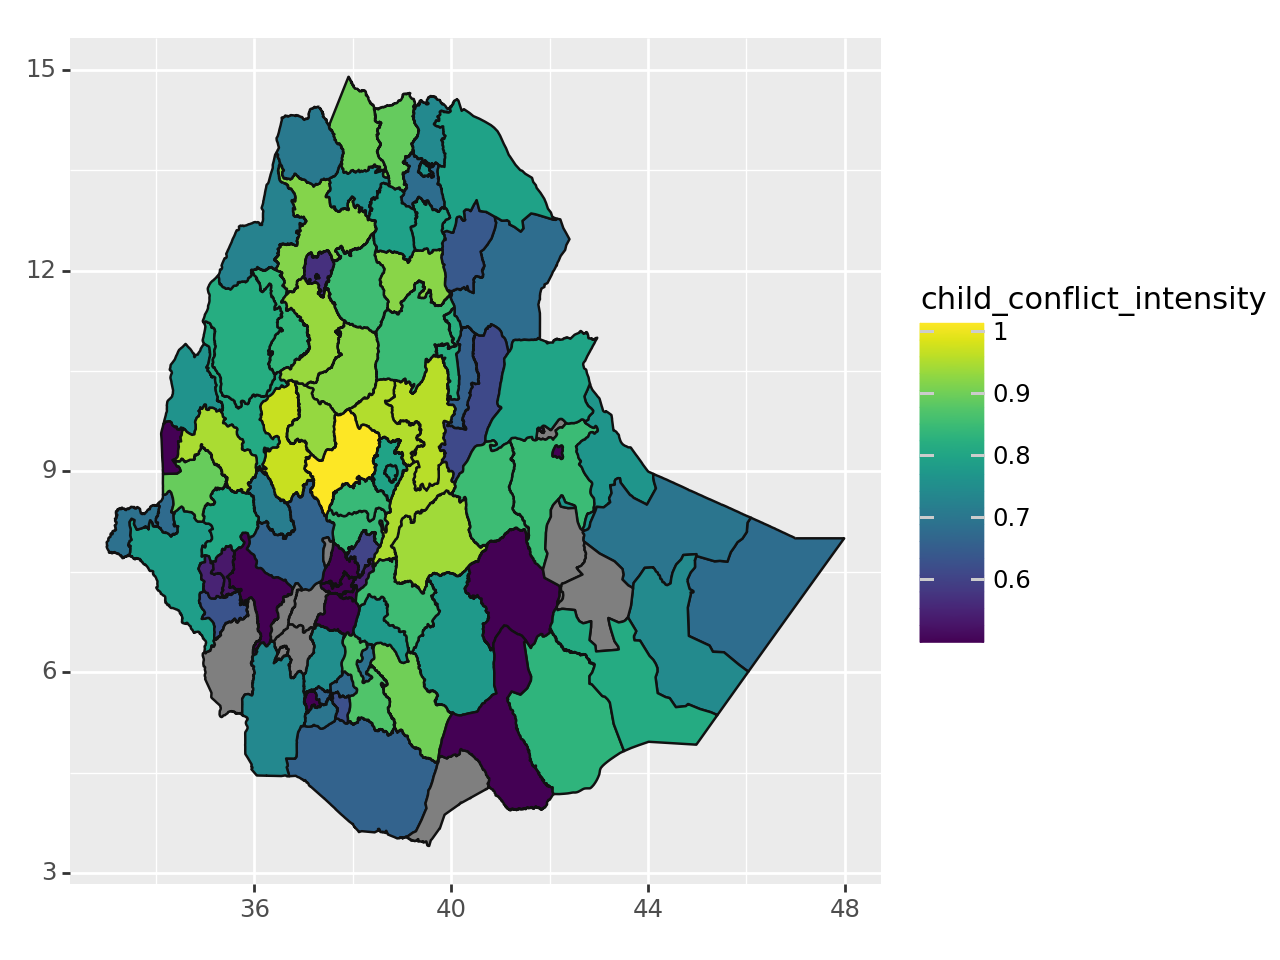

<Figure Size: (640 x 480)>

In [31]:
child_conflict_map(df.query("year > 2021"), "Ethiopia", "ETH")